# Feed Forward Neural Networks

## What we will accomplish

In this notebook we will:
- Introduce Feed Forward Neural Networks
- Demonstrate how to implement them using `keras`.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

import pprint

## Feed forward network architecture

Recall our parametric supervised learning framework: 
* We have *data* of the form $D = {(x_i, y_i)}$ with $x_i \in \mathbb{R}^p$ and $y_i \in \mathbb{R}^m$. 
* We have a collection of *hypothesized relationships* $f_\theta : \mathbb{R}^p \to \mathbb{R}^m$ depending on some *parameters* $\theta \in \Theta$.
* We have a *loss function* $\ell$ which takes as input a dataset $D$ and hypothesized function $f_\theta$ and returns a positive real number.
* We *fit* a model by finding the parameters which minimize the loss (at least approximately, if not exactly).

Feed Forward Neural Networks fit into this framework.  Our collection of hypothesized relationships have the following special form:

$$
f_\theta: \mathbb{R}^p \stackrel{A_1}{\longrightarrow} \mathbb{R}^{h_1} \stackrel{\sigma_1}{\longrightarrow} \mathbb{R}^{h_1} \stackrel{A_2}{\longrightarrow} \mathbb{R}^{h_2} \stackrel{\sigma_2} {\longrightarrow} \mathbb{R}^{h_2} \stackrel{A_3}{\longrightarrow} \dots \stackrel{\sigma_{k-1}} {\longrightarrow} \mathbb{R}^{h_{k-1}} \stackrel{A_{k}}{\longrightarrow} \mathbb{R}^{h_k} \stackrel{\sigma_{k}} {\longrightarrow} \mathbb{R}^{h_k} \stackrel{A_{k+1}}{\longrightarrow} \mathbb{R}^m \stackrel{\sigma_{k+1}} {\longrightarrow} \mathbb{R}^m
$$

Here each $A_i$ is an affine function of the form $A_i(\vec{x}) = W_i\vec{x} + b_i$ and each $\sigma_i$ is a non-linear function.  The most common choice for $\sigma_i$ is $\operatorname{ReLU}(x) = \max(0,x)$ (which is applied to each coordinate independently).

Note that if we *do* take all $\sigma_i = \operatorname{ReLU}$, then $f_\theta$ is a piecewise linear function.  This gives us an extremely flexible hypothesis class:  in fact one can prove that just taking functions of the form $f: \mathbb{R}^p \to \mathbb{R}^m$ of the form $f =  A_2 \circ \operatorname{ReLU} \circ A_1$ is sufficiently flexible to allow us to uniformly approximate **any** continuous function on a compact domain (given a large enough intermediate dimension $h$).  Results of this nature go by the name of [universal approximation theorems](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

It is common to visualize neural networks with pictures like the following:

<img src="lecture_12_assets/network1.png" width="60%"></img>

The way to interpret this is that each circle represents a coordinate, each arrow represents an entry of a matrix $W_i$, and the activation functions and biases are omitted from the picture.

For instance the function $f:\mathbb{R}^3 \to \mathbb{R}^2$ given by $f(\vec{x}) = \operatorname{ReLU}(W\vec{x})$ with $W = \begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6\end{bmatrix}$ could be visualized with the following picture:

<img src="lecture_12_assets/network2.png" width="30%"></img>

$$
f_\theta: \mathbb{R}^p \stackrel{A_1}{\longrightarrow} \mathbb{R}^{h_1} \stackrel{\sigma_1}{\longrightarrow} \mathbb{R}^{h_1} \stackrel{A_2}{\longrightarrow} \mathbb{R}^{h_2} \stackrel{\sigma_2} {\longrightarrow} \mathbb{R}^{h_2} \stackrel{A_3}{\longrightarrow} \dots \stackrel{\sigma_{k-1}} {\longrightarrow} \mathbb{R}^{h_{k-1}} \stackrel{A_{k}}{\longrightarrow} \mathbb{R}^{h_k} \stackrel{\sigma_{k}} {\longrightarrow} \mathbb{R}^{h_k} \stackrel{A_{k+1}}{\longrightarrow} \mathbb{R}^m \stackrel{\sigma_{k+1}} {\longrightarrow} \mathbb{R}^m
$$

Some neural network specific terminology:

Each $\mathbb{R}^{d}$ in the chain is called a **layer**.  Sometimes the map "$\sigma_i \circ A_i$" is called the "layer" instead.  
* The first $\mathbb{R}^p$ is called the **input layer**.
* The last $\mathbb{R}^m$ is called the **output layer**.
* Intermediate $\mathbb{R}^{h_i}$ are called **hidden layers**.
* Each coordinate of each $\mathbb{R}^d$ is called a **neuron**.
* The $\sigma_i$ are called **activation functions**.  
    * The analogy is to a neuron firing or not depending on the strength of a stimulus.
    * It is common for $\sigma_i = \operatorname{ReLU}$ for $i \in \{1,2,3,\dots k\}$.
    * It is common for the final activation function $\sigma_{k+1}$ to be specially chosen to fit the problem at hand.
        * For regression it is common to use the identity function as the activation function and use mean squared error as our loss function.
        * For binary classification it is common to use the sigmoid function as the activation function and use binary cross-entropy as our loss function.
        * For multi-class classification it is common to use $\operatorname{SoftMax}(\vec{x}) = (\frac{\exp(x_i)}{\sum_1^m \exp(x_j)})_i$ as the activation function and categorical cross-entropy as our loss function.
        * For multi-label classification it is common to use the sigmoid function (applied component-wise) as the activation function and use the mean binary cross-entropy across all classes as the loss function.
* Each individual entry of the matrix $W_i$ is called a **weight**.
* Each individual entry of the vector $b_i$ is called a **bias**.
* Taken together the weights and biases are the **parameters** of the model.
* The full specification of allowable $f_\theta$ is called the **model architecture**.
    * For now this just looks like specifying the dimensions and activation functions, but we will soon see that we can place additional restrictions on the $A_i$
    * One example is specifying that the weight matrix $W_i$ must have a particular constrained form.
    * If there are no special constraints on $A_i$ it is called a **linear layer**, **fully connected layer**, or **dense layer**.
* Using a numerical algorithm to adjust the parameters to decrease the loss function is called **training** the neural network.
    * We will most frequently use some variant of gradient descent.
* A trained model (i.e. an architecture together with specific values for the weights and biases) is called a **checkpoint**.

Note that a fully connected feed forward neural network will have $(p+1)h_1 + (h_1 +1)h2 + \dots + (h_i + 1)h_{i+1} + \dots + (h_k + 1)m$ parameters!  This can really add up quickly.

## A naive implementation

Let's implement our own version of a feed forward ReLU network to better understand the structure.  

We only need to specify a list of dimensions for each layer and (optionally) a final activation function.

In [2]:
class ReLUNN():
    '''A FFNN whose layers have dimensions [p,h_1,h_2,..., h_k, m] and uses RELU activation in all but the final layer'''
    def __init__(self,dims,sigma = None):
        self.dims = dims
        self.l = len(dims) - 1 # number of functions between layers
        self.weights = [np.random.randn(dims[i+1],dims[i]) for i in range(self.l)] # randomly initialize weights
        self.biases = [np.random.randn(dims[i+1], 1) for i in range(self.l)] # making bias shape (-1,1) so addition with a matrix broadcasts correctly.
        self.sigma = sigma
    
    @staticmethod
    def _relu(t):
        '''Takes input numpy array and sets negative entries to 0.0'''
        t[t<0] = 0.0
        return t
    
    def predict(self, X):
        '''Takes matrix of features X as input, applies layers, then applies final activation function sigma'''
        X = X.astype(float)
        X = X.transpose() # rows of design matrix are inputs of predict
        for i in range(self.l):
            X = np.dot(self.weights[i], X) + self.biases[i]
            if i != self.l-1:
                X = self._relu(X)
        if self.sigma:
            X = self.sigma(X)
        return X.transpose() # rows of output matrix are the predictions

In [3]:
nn = ReLUNN(dims = [2,3,1], sigma= None)
pprint.pprint(nn.__dict__)
X = np.array([[.1,.2],[.3,.4],[.5,.6]])
print(f"f(X) = {nn.predict(X)}")

{'biases': [array([[-2.2679321 ],
       [ 0.85035618],
       [ 1.8291988 ]]),
            array([[-0.01102683]])],
 'dims': [2, 3, 1],
 'l': 2,
 'sigma': None,
 'weights': [array([[-0.0860524 ,  0.92425164],
       [-0.4432754 , -1.05500051],
       [-0.7378693 ,  0.69149764]]),
             array([[0.10359912, 0.73699198, 0.0127846 ]])]}
f(X) = [[0.45171478]
 [0.23075274]
 [0.01294638]]


The weights and biases would be adjusted during training to minimize the loss function.  After this is done we would predict as above!

## We have already seen some Neural Networks!

Several of the machine learning techniques we have covered can be seen as simple neural networks.  For example:

* Linear Regression
    * We have a set of hypothesized relationships of the form $\mathbb{R^p} \stackrel{A_1}{\longrightarrow} \mathbb{R}$.
    * Our loss function is Mean Squared Error.
    * In neural network terminology we are training a single layer network with no activation function.
* Logistic Regression
    * We have a set of hypothesizes relationships of the form $\mathbb{R^p} \stackrel{A_1}{\longrightarrow} \mathbb{R} \stackrel{\sigma}{\longrightarrow} \mathbb{R}$ where $\sigma$ is the sigmoid activation function.
    * Our loss function is binary cross-entropy.
* Multiclass Logistic Regression
    * We have a set of hypothesizes relationships of the form $\mathbb{R^p} \stackrel{A_1}{\longrightarrow} \mathbb{R^m} \stackrel{\operatorname{SoftMax}}{\longrightarrow} \mathbb{R}^m$ where $\operatorname{SoftMax}(\vec{a})$ has $i^{th}$ coordinate $\frac{\exp(a_i)}{\sum \exp(a_j)}$.
    * We use categorical cross-entropy as our loss function.


### Training a Neural Network:  Gradient Descent

In many of the machine learning algorithms we have covered so far, minimizing the loss function is relatively simple:

* In linear regression we have an explicit solution of the parameters which minimize the MSE.
* In logistic regression and SVM we don't have an explicit solutions, but we *do* have simple explicit formulas for the gradient and Hessian of the loss function which makes numerical optimization very fast.
* Many of the other techniques we have covered also have convex loss functions and/or have optimization algorithms which make training relatively quick and inexpensive.

Neural Networks are different.  The loss function, thought of as a function of the parameters, is often **highly** non-convex. Despite this (and somewhat mysteriously I might add!) neural networks trained using good old fashioned Gradient Descent are capable of amazing feats like writing poetry, identifying what song is playing on the radio, and driving cars!  Here is a brief summary of how Gradient Descent works:

* Choose a **learning rate** $\textrm{lr}$.
* Initialize your parameters $\theta$ randomly as $\theta_0$.
* At each stage $j$:
    * Compute the gradient of the loss function $\nabla \ell \big|_{\theta_j}$.
    * Set $\theta_{j+1} = \theta_j - \textrm{lr} \nabla \ell \big|_{\theta_j}$
* Stop when you reach some stopping condition (often when validation loss stops decreasing).

In the following picture we are showing the contour lines of a loss function of two parameters.  The gradient points in the direction of steepest ascent ("straight up the hill") while the negative gradient points in the direction of steepest descent ("straight down the hill").  The gradient descent algorithm just has us start at a random point and take one little step at a time in the direction which carries us down the fastest. This will generally lead us to a local (but not necessarily global) minimum of the loss function.

<img src="lecture_12_assets/contour.png" width="40%"></img>

The gradient is computed using the chain rule, which in this context is known as **backpropagation**.  Technically backpropagation is not just the chain rule, but is a specific numerical implementation of the chain rule which avoids the inefficiencies of a naive implementation.  You can think of it as roughly [chain rule](https://en.wikipedia.org/wiki/Chain_rule) + [memoization](https://en.wikipedia.org/wiki/Memoization) = [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).  Note:  a previous Erdős Alumni said this to me (Steven Gubkin) in conversation and I believe they may have coined the phrase.  I do not recall who that was though!

#### Common adjustments to the gradient descent

Common adjustments to the gradient descent step:

1. Calculating the gradient of your loss function using a subset of your data rather than all of the data.  This is called **batch gradient descent**.  In the case that your batch size is one this is called **stochastic gradient descent**.  Getting through all of your data is called one **epoch**.

2. Adjusting your learning rate during training (aka adopting a **learning rate schedule**).  There are numerous methods.

3. [This wikipedia page](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) contains an exposition of many different varients.

## Training simple feed forward neural networks with Keras

In [ ]:
#!pip install tensorflow

In [6]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow import convert_to_tensor

### A synthetic regression example

We will show how to approximate $\sin$ on the interval $[1,4]$ using a function of the form

$$
[1,4] \stackrel{A_1}{\longrightarrow} \mathbb{R}^9 \stackrel{\operatorname{ReLU}}{\longrightarrow} \mathbb{R}^9 \stackrel{A_2}{\longrightarrow} \mathbb{R}^1
$$

by using a version of gradient descent called "RMSProp" to minimize the mean squared error loss between model outputs and true outputs.

In [7]:
X = convert_to_tensor(np.linspace(1, 4, 1000))
y = convert_to_tensor(np.sin(X)+ 0.05*np.random.randn(1000))

model = keras.Sequential([
    layers.InputLayer((1,)),
    layers.BatchNormalization(axis = -1), # equivalent of StandardScaler().  Puts inputs on "same scale" as initial parameters, which helps with training.
    layers.Dense(9, activation = 'relu'), # R^1 --> R^9 with ReLU activation
    layers.Dense(1) # back down to R^1 again with a pure linear layer
])

model.compile(optimizer = "rmsprop", # version of gradient descent which adjusts learning rate dynamically
              loss = "mse", # Mean Squared Error loss function
              )

model.fit(X, y, epochs = 100) # we do 100 steps of the gradient descent algorithm

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8608   
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6206 
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4587 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 0.3758
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.2829
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.2117
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.1466
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.0984
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0711 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.0405
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0346
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0296 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0198 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0251 
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


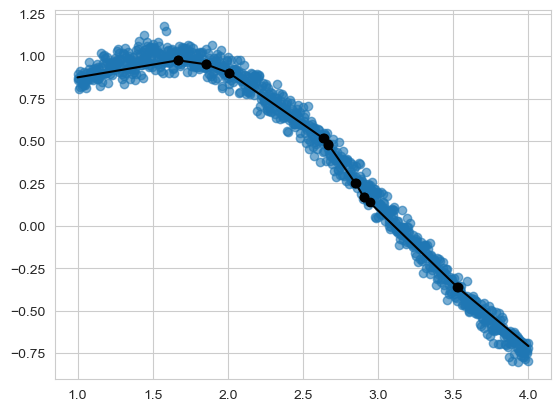

In [8]:
preds = model.predict(X).reshape(-1)

plt.scatter(X,y, alpha = 0.6)
plt.plot(X, preds, 'k')
# plotting points where the slope changes
for i in range(1,len(preds)-1):
    if np.abs((preds[i] - preds[i-1]) - (preds[i+1] - preds[i])) > 0.00001:
        plt.plot(X[i], preds[i], 'ko')
plt.show()

Note that our approximation is piecewise linear! We can extract the weights and biases as follows:

In [9]:
model.weights

[<Variable path=sequential/batch_normalization/gamma, shape=(1,), dtype=float32, value=[1.128922]>,
 <Variable path=sequential/batch_normalization/beta, shape=(1,), dtype=float32, value=[-0.12447109]>,
 <Variable path=sequential/batch_normalization/moving_mean, shape=(1,), dtype=float32, value=[2.4941754]>,
 <Variable path=sequential/batch_normalization/moving_variance, shape=(1,), dtype=float32, value=[0.7277823]>,
 <Variable path=sequential/dense/kernel, shape=(1, 9), dtype=float32, value=[[-1.0693733   0.69959736 -0.48198196  0.09576492  0.6758302  -0.19036168
    0.16574618  0.2647504  -0.41783458]]>,
 <Variable path=sequential/dense/bias, shape=(9,), dtype=float32, value=[ 0.44745713 -0.07298011 -0.36999533 -0.11870601 -0.0419896  -0.23134115
  -0.07766632 -0.09080911 -0.4062383 ]>,
 <Variable path=sequential/dense_1/kernel, shape=(9, 1), dtype=float32, value=[[ 0.43365923]
  [-0.19405712]
  [-0.43819404]
  [ 0.9705877 ]
  [-0.5310714 ]
  [-1.0842184 ]
  [-0.11408314]
  [-0.507195

Can we use just these weights and biases to recover the picture we drew above?  

We could, but the batch normalization layer makes things a bit more complicated. 

Let's rerun it with the first two lines line commented out.  Note that I specified the input shape in the first Dense layer this time.

In [10]:
model = keras.Sequential([
    #layers.InputLayer(1),  
    #layers.BatchNormalization(axis = -1), # equivalent of StandardScaler().  Puts inputs on "same scale" as initial parameters, which helps with training.
    layers.Dense(9, activation = 'relu', input_shape=(1,)), # R^1 --> R^9 with ReLU activation
    layers.Dense(1) # back down to R^1 again with a pure linear layer
])

model.compile(optimizer = "rmsprop", # version of gradient descent which adjusts learning rate dynamically
              loss = "mse", # Mean Squared Error loss function
              metrics = ["mean_squared_error"])

model.fit(X, y, epochs = 200) # we do 200 steps of the gradient descent algorithm

Epoch 1/200


/opt/homebrew/Caskroom/miniforge/base/envs/erdos_spring_2025/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5230 - mean_squared_error: 0.5230  
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4477 - mean_squared_error: 0.4477 
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3958 - mean_squared_error: 0.3958 
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.3580 - mean_squared_error: 0.3580
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.3161 - mean_squared_error: 0.3161
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.2819 - mean_squared_error: 0.2819
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.2524 - mean_squared_error: 0.2524
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.2123 - mean_squared_error: 0.2123
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1804 - mean_squared_error: 0.1804 
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1546 - mean_squared_error: 0.1546 
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

In [11]:
# Putting weights in the form of our custom class

W_1 = model.weights[0].numpy().transpose()
b_1 = model.weights[1].numpy().reshape(-1,1)
W_2 = model.weights[2].numpy().transpose()
b_2 = model.weights[3].numpy().reshape(-1,1)

In [12]:
W_1.shape, b_1.shape, W_2.shape, b_2.shape

((9, 1), (9, 1), (1, 9), (1, 1))

In [13]:
def relu(x):
    x[x<0] = 0
    return x

In [14]:
inputs = X.numpy().reshape(1,-1)
y_np = b_2 + np.dot(
    W_2,
    relu(
        np.dot(W_1, inputs) + b_1
        )
    )

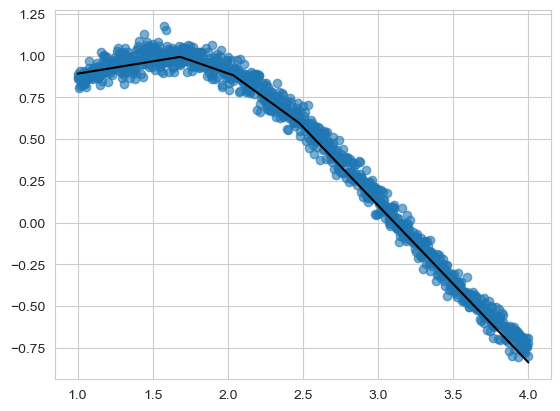

In [15]:
plt.scatter(X,y, alpha = 0.6)
plt.plot(X, y_np.reshape(-1), "k")
plt.show()

Alternatively, we can make sure that our `RelUNN` class functions properly by plugging these learned weights in.

In [16]:
nn = ReLUNN(dims = [1,9,1])
nn.weights = [W_1,W_2]
nn.biases = [b_1, b_2]
nn_preds = nn.predict(X.numpy().reshape(-1,1))

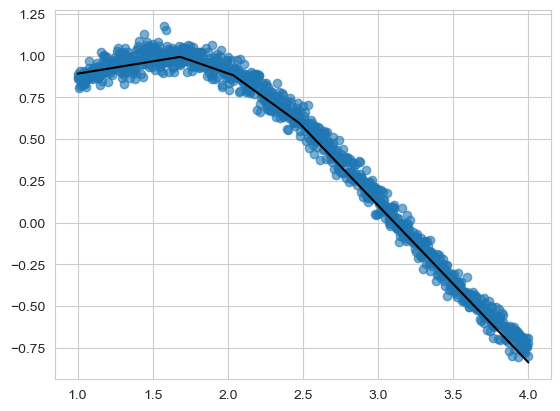

In [17]:
plt.scatter(X,y, alpha = 0.6)
plt.plot(X, nn_preds, "k")
plt.show()

### A regression example with real data.

We use the same concrete data from problem set 11.

Yeh,I-Cheng. (2007). Concrete Compressive Strength. UCI Machine Learning Repository. https://doi.org/10.24432/C5PK67.

In [18]:
concrete = pd.read_csv("../../data/concrete.csv") 
concrete

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
features = concrete.columns[:-1]
target = concrete.columns[-1]

X_train, X_test, y_train, y_test = train_test_split(concrete[features],concrete[target], test_size=0.2, random_state=216)

X_tt,X_val, y_tt, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=216)

X_train_tensor = convert_to_tensor(X_train)
y_train_tensor = convert_to_tensor(y_train)
X_tt_tensor = convert_to_tensor(X_tt)
X_val_tensor = convert_to_tensor(X_val)
X_test_tensor = convert_to_tensor(X_test)
y_tt_tensor = convert_to_tensor(y_tt)
y_val_tensor = convert_to_tensor(y_val)
y_test_tensor = convert_to_tensor(y_test)

In [21]:
# Showcasing a learning rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01, #initial learning rate
    decay_steps= 1000 , # After 1000 steps we start to decrease the learning rate
    decay_rate=0.95, # multiply learning rate by 0.95 for each epoch after
    staircase=True)

model = keras.Sequential([
    layers.InputLayer((8,)),
    layers.BatchNormalization(axis = -1),
    layers.Dense(20, activation = 'relu'),
    layers.Dense(20, activation = 'relu'),
    layers.Dense(1,kernel_regularizer=keras.regularizers.L2(0.01)) # Showing how to regularize weights
])

model.compile(keras.optimizers.Adam(learning_rate=lr_schedule), loss = "mse", metrics= [keras.metrics.RootMeanSquaredError()])

history = model.fit(X_tt_tensor, y_tt_tensor, epochs = 200, validation_data = (X_val_tensor, y_val_tensor), batch_size = 32) # we do 200 steps of the gradient descent algorithm

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1418.9600 - root_mean_squared_error: 37.6355 - val_loss: 8918.6426 - val_root_mean_squared_error: 94.4384
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 371.8699 - root_mean_squared_error: 19.2003 - val_loss: 16242.2002 - val_root_mean_squared_error: 127.4447
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 195.9467 - root_mean_squared_error: 13.9769 - val_loss: 4989.4175 - val_root_mean_squared_error: 70.6355
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 140.7946 - root_mean_squared_error: 11.8552 - val_loss: 1347.9674 - val_root_mean_squared_error: 36.7141
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 141.1107 - root_mean_squared_error: 11.8639 - val_loss: 414.1774 - val_root_mean_squared_error: 20.3504
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 127.0089 - root_mean_squared_error: 11.2586 - val_loss: 223.1961 - val_root_mean_squared_error: 14.9385
Epoch 7/200
21/

This is a really simple fully connected NN with two hidden layers. It gives us pretty similar performance to RandomForestRegressor without doing any hyperparameter tuning.

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_tt,y_tt)
np.sqrt(mean_squared_error(rfr.predict(X_val),y_val))

np.float64(6.151383842532183)

### A classificiation example

In [24]:
t = np.linspace(0,4*np.pi, 500)
X_0 = np.stack([t*np.cos(t), t*np.sin(t)], axis = 0).transpose() + 0.5*np.random.standard_normal((500,2))
X_1 = np.stack([(t+1.2)*np.cos(t), (t+1.2)*np.sin(t)], axis = 0).transpose() + 0.5*np.random.standard_normal((500,2))
X = np.concatenate([X_0,X_1], axis = 0)
y = np.concatenate([np.zeros(500), np.ones(500)])

In [25]:
y.shape

(1000,)

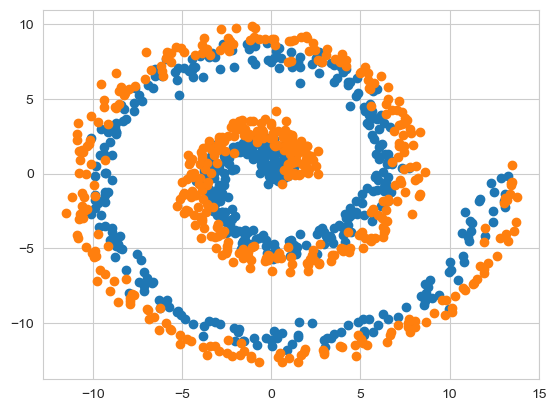

In [26]:
plt.scatter(X_0[:,0],X_0[:,1])
plt.scatter(X_1[:,0],X_1[:,1])

plt.show()

In [27]:
clf = keras.Sequential([
    layers.InputLayer((2,)),
    layers.Normalization(axis=-1), # Basically StandardScaler()
    layers.Dense(50, activation = 'relu', use_bias = True ,input_shape=(2,)), # R^2 --> R^12 with ReLU activation
    layers.Dense(50, activation = 'relu', use_bias = True), # R^12 --> R^12 with ReLU activation
    layers.Dense(1, use_bias = True, activation = 'sigmoid') # R^12 --> R^1 again with sigmoid activation
])

clf.compile(optimizer = "rmsprop", 
              loss = "binary_crossentropy", 
              metrics = ["accuracy"])

clf.fit(X, y, epochs = 500) 

Epoch 1/500


/opt/homebrew/Caskroom/miniforge/base/envs/erdos_spring_2025/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4862 - loss: 0.7340   
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5369 - loss: 0.6968 
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5457 - loss: 0.6950 
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5431 - loss: 0.6967 
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5305 - loss: 0.6889 
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4993 - loss: 0.6959 
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5388 - loss: 0.6895 
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.6833 
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5440 - loss: 0.6895 
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 0.6897 
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5260 - loss: 0.6827 
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

In [28]:
xx, yy = np.mgrid[-12:16:.1, -15:12:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict(grid).reshape(xx.shape)

2363/2363 ━━━━━━━━━━━━━━━━━━━━ 1s 335us/step


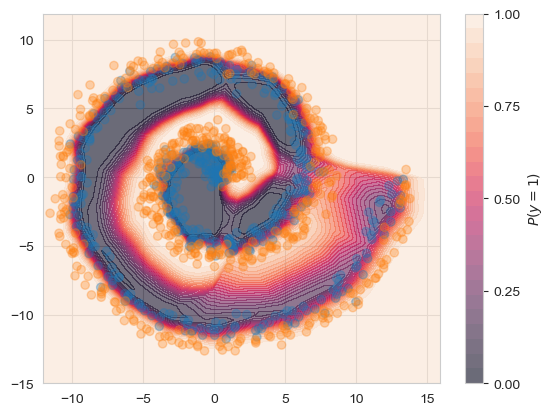

In [29]:
contour = plt.contourf(xx, yy, probs, 25, alpha = 0.6,
                      vmin=0, vmax=1)
ax_c = plt.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.scatter(X[:,0],X[:,1],  c = [colors[int(j)] for j in y], alpha = 0.3)

plt.show()

### Comparison to PyTorch

We have been utilizing Tensorflow for this introduction to Neural Networks because the API is easier to use for basic examples.  However, Tensorflow is not as easily customizable as PyTorch.  It is also not as "pythonic".  For these reasons the industry has been strongly moving towards PyTorch as the standard deep learning library.

Let's take a look at what the same classifier would look like implemented in PyTorch.  You will see that it abstracts away less of the training process.

We will stick to Tensorflow for the rest of this lecture as the code is a little easier to comprehend for a deep learning beginner.  Our Deep Learning bootcamp uses PyTorch.

In [31]:
!pip install torch

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 29.9 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler

# Generate the data
t = np.linspace(0, 4*np.pi, 500)
X_0 = np.stack([t * np.cos(t), t * np.sin(t)], axis=0).transpose() + 0.5 * np.random.standard_normal((500, 2))
X_1 = np.stack([(t + 1.2) * np.cos(t), (t + 1.2) * np.sin(t)], axis=0).transpose() + 0.5 * np.random.standard_normal((500, 2))
X = np.concatenate([X_0, X_1], axis=0)
y = np.concatenate([np.zeros(500), np.ones(500)])

# Standardize the data (equivalent to layers.Normalization in Keras)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Make y a column vector

# Define the model
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.dense1 = nn.Linear(2, 50)  # Dense layer: R^2 --> R^50
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(50, 50)  # Dense layer: R^50 --> R^50
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(50, 1)  # Dense layer: R^50 --> R^1
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation

    def forward(self, x):
        x = self.relu1(self.dense1(x))
        x = self.relu2(self.dense2(x))
        x = self.sigmoid(self.dense3(x))
        return x

# Initialize the model, loss function, and optimizer
model = SimpleClassifier()
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.RMSprop(model.parameters(), lr=0.001)  # RMSProp optimizer

# Training loop
epochs = 2000
for epoch in range(epochs):
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(X_tensor)

    # Compute the loss
    loss = criterion(output, y_tensor)

    # Backward pass (compute gradients)
    loss.backward()

    # Update the model parameters
    optimizer.step()

    if epoch % 100 == 0:  # Print loss and accuracy every 100 epochs
        predictions = (output > 0.5).float()  # Convert probabilities to binary predictions
        accuracy = (predictions == y_tensor).float().mean()  # Calculate accuracy
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy.item()}')


Epoch 0/2000, Loss: 0.6922019124031067, Accuracy: 0.4959999918937683
Epoch 100/2000, Loss: 0.6555314660072327, Accuracy: 0.5239999890327454
Epoch 200/2000, Loss: 0.6260358095169067, Accuracy: 0.6420000195503235
Epoch 300/2000, Loss: 0.5923441648483276, Accuracy: 0.722000002861023
Epoch 400/2000, Loss: 0.558756947517395, Accuracy: 0.7829999923706055
Epoch 500/2000, Loss: 0.5269586443901062, Accuracy: 0.8159999847412109
Epoch 600/2000, Loss: 0.4970411956310272, Accuracy: 0.8299999833106995
Epoch 700/2000, Loss: 0.47161075472831726, Accuracy: 0.8370000123977661
Epoch 800/2000, Loss: 0.44951289892196655, Accuracy: 0.843999981880188
Epoch 900/2000, Loss: 0.43077635765075684, Accuracy: 0.8510000109672546
Epoch 1000/2000, Loss: 0.4118638336658478, Accuracy: 0.8550000190734863
Epoch 1100/2000, Loss: 0.3973506987094879, Accuracy: 0.8539999723434448
Epoch 1200/2000, Loss: 0.3848593831062317, Accuracy: 0.859000027179718
Epoch 1300/2000, Loss: 0.3744790256023407, Accuracy: 0.8610000014305115
Epoch

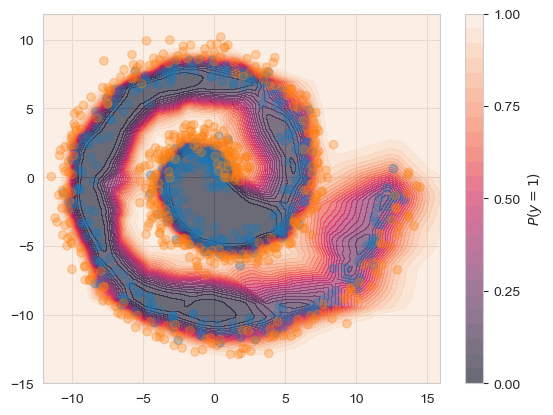

In [33]:
import torch
import numpy as np

# Create the grid
xx, yy = np.mgrid[-12:16:.1, -15:12:.1]
grid = np.c_[xx.ravel(), yy.ravel()]

# Convert the grid to a PyTorch tensor
grid_tensor = torch.tensor(scaler.transform(grid), dtype=torch.float32)

# Get the model's predictions (use the trained model from previous code)
model.eval()  # Set the model to evaluation mode (no gradient updates)
with torch.no_grad():  # No need to compute gradients
    probs = model(grid_tensor).reshape(xx.shape).detach().numpy()  # Get the probabilities and reshape to match the grid

contour = plt.contourf(xx, yy, probs, 25, alpha = 0.6,
                      vmin=0, vmax=1)
ax_c = plt.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.scatter(scaler.inverse_transform(X)[:,0],scaler.inverse_transform(X)[:,1],  c = [colors[int(j)] for j in y], alpha = 0.3)

plt.show()


--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.